In [1]:
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch

from gpytorch.kernels import MaternKernel, ScaleKernel
from botorch.models import SingleTaskGP, SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
# 設定最小閾值
FLOOR = 1e-10

# 數值處理：確保不低於 1e-10
def preprocess_regret(regrets):
    return [max(r, FLOOR) for r in regrets]

def read_model_lengthscale(model_path):
    checkpoint = torch.load(model_path, weights_only=False)
    # 2. 用儲存的數據初始化模型結構
    covar_module = checkpoint["covar_module"]
    train_x = checkpoint['train_X']
    train_y = checkpoint['train_Y'].unsqueeze(-1)
    new_model = SingleTaskGP(
                train_x,
                train_y,
                covar_module=covar_module,
                outcome_transform=Standardize(m=train_y.shape[-1])
            )

    # 3. 載入參數
    new_model.load_state_dict(checkpoint['model_state_dict'])

    # 4. 讀取 lengthscales
    kernel_name = new_model.covar_module._get_name()
    if kernel_name == 'RBFKernel':
        length_scales = new_model.covar_module.lengthscale.cpu().detach().numpy()
    elif kernel_name == 'ScaleKernel':
        length_scales = new_model.covar_module.base_kernel.lengthscale.cpu().detach().numpy()

    return length_scales


/home/appuser/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser(description="Generate Scheffe Benchmark Suite")
parser.add_argument("--json_paths", type=str, help="output bo result path", nargs='+')
parser.add_argument("--model_paths", type=str, help="output bo model path", nargs='+')
parser.add_argument("--output_plot_dir", type=str, default='./datasets/D=5_N=5', help="output plot path")


# 模擬命令行輸入
args_list = [
    '--json_paths',
    '/workspaces/BO_EXPERIMENTS/src/results/20260122/D=5_N=3_K=3/matern_ard_bo/jsonfiles/oracle_data_D5_C_000.json',
    '/workspaces/BO_EXPERIMENTS/src/results/20260122/D=5_N=3_K=3/matern_ard_bo/jsonfiles/oracle_data_D5_C_001.json',
    '/workspaces/BO_EXPERIMENTS/src/results/20260122/D=5_N=3_K=3/matern_ard_bo/jsonfiles/oracle_data_D5_C_002.json',
    '--model_paths',
    '/workspaces/BO_EXPERIMENTS/src/results/20260122/D=5_N=3_K=3/matern_ard_bo/models/oracle_data_D5_C_000_botorch_model.pth',
    '/workspaces/BO_EXPERIMENTS/src/results/20260122/D=5_N=3_K=3/matern_ard_bo/models/oracle_data_D5_C_001_botorch_model.pth',
    '/workspaces/BO_EXPERIMENTS/src/results/20260122/D=5_N=3_K=3/matern_ard_bo/models/oracle_data_D5_C_002_botorch_model.pth',
    '--output_plot_dir',
    '/workspaces/BO_EXPERIMENTS/src/results/20260122/D=5_N=3_K=3/matern_ard_bo/plots/'
]
args = parser.parse_args(args=args_list)

# args = parser.parse_args()

In [3]:
json_paths = args.json_paths
output_plot_dir = args.output_plot_dir
model_paths = args.model_paths

In [4]:
# 讀取 result.json 檔案
results_list = []
for json_path in json_paths:
    with open(json_path, 'r') as f:
        result = json.load(f)
        results_list.append(result)

# 創建圖片儲存位置
os.makedirs(output_plot_dir, exist_ok=True)

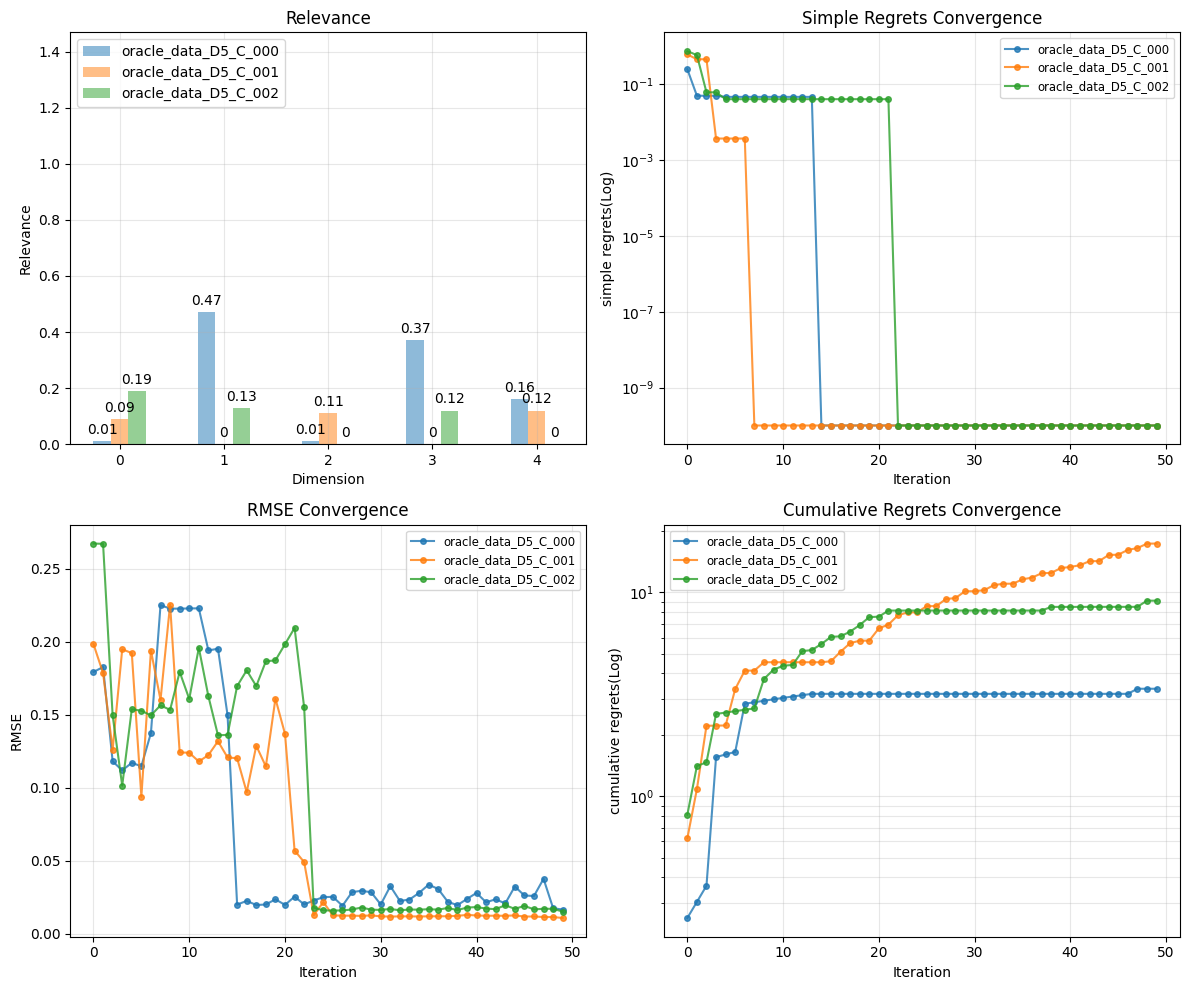

In [5]:
rows, cols = 2,2
fig, axes = plt.subplots(rows, cols, figsize=(12,10))
colors = plt.cm.tab10.colors
axes = axes.flatten()


plot_types = ['relevance', 'simple_regrets', 'mse','cumulative_regrets']
for j, plot_type in enumerate(plot_types):
    ax = axes[j]
    if plot_type in ['simple_regrets']:
        for i, result in enumerate(results_list):
            # 取得標籤 (從檔案路徑提取檔名)
            label = os.path.splitext(os.path.basename(result['dataset_path']))[0]
            color = colors[i % 10] # 使用固定 10 色循環
            regrets = result[plot_type]
            ax.plot(preprocess_regret(regrets), label=label, marker='o', color=color, markersize=4, alpha=0.8)

        ax.set_yscale('log')
        ax.set_ylabel("{}(Log)".format(plot_type).replace('_', ' '))
        ax.set_xlabel('Iteration')
        title = '{} Convergence'.format(plot_type.replace('_', ' '))
        formatted_title = " ".join([word.capitalize() for word in title.split()])
        ax.set_title(formatted_title)
        ax.grid(True, which="both", ls="-", alpha=0.3)
        ax.legend(fontsize='small')
    elif plot_type == 'cumulative_regrets':
        for i, result in enumerate(results_list):
            # 取得標籤 (從檔案路徑提取檔名)
            label = os.path.splitext(os.path.basename(result['dataset_path']))[0]
            color = colors[i % 10] # 使用固定 10 色循環

            n_inter = len(result['inference_regrets'])
            candidates_x = result['final_train_x'][-n_inter:]
            candidates_y = np.array(result['final_train_obj'][-n_inter:])
            gt_y = result['gt_y']

            initial_regrets = np.maximum(gt_y - candidates_y, 0).squeeze()
            cumulative_regrets = np.cumsum(initial_regrets)

            ax.plot(preprocess_regret(cumulative_regrets.tolist()), label=label, marker='o', color=color, markersize=4, alpha=0.8)

        ax.set_yscale('log')
        ax.set_ylabel("{}(Log)".format(plot_type).replace('_', ' '))
        ax.set_xlabel('Iteration')
        title = '{} Convergence'.format(plot_type.replace('_', ' '))
        formatted_title = " ".join([word.capitalize() for word in title.split()])
        ax.set_title(formatted_title)
        ax.grid(True, which="both", ls="-", alpha=0.3)
        ax.legend(fontsize='small')
    elif plot_type == 'mse':
        for i, result in enumerate(results_list):
            # 取得標籤 (從檔案路徑提取檔名)
            label = os.path.splitext(os.path.basename(result['dataset_path']))[0]
            color = colors[i % 10] # 使用固定 10 色循環
            regrets = result['mse_ls']
            mse = preprocess_regret(regrets)
            rmse = np.sqrt(mse)
            ax.plot(rmse, label=label, marker='o', color=color, markersize=4, alpha=0.8)

        # ax.set_yscale('log')
        ax.set_ylabel('RMSE')
        ax.set_xlabel('Iteration')
        ax.set_title("{} Convergence".format('RMSE'))
        ax.grid(True, which="both", ls="-", alpha=0.3)
        ax.legend(fontsize='small')
        
    elif plot_type == 'relevance':
        total_width = 0.5  # 每一群組佔用的總寬度
        y_max = 0
        for i, result in enumerate(results_list):
            n_dim = len(result['gt_x'])
            label = os.path.splitext(os.path.basename(result['dataset_path']))[0]
            color = colors[i % 10] # 使用固定 10 色循環
            width = total_width / len(results_list)  # 單一柱子的寬度
            model_path = model_paths[i]  # 對應的模型檔案
            length_scales = read_model_lengthscale(model_path)
            
            # 確保 length_scales 與維度數量匹配
            n_dim = len(result['gt_x'])
            if length_scales.shape[-1] != n_dim:
                length_scales = np.tile(length_scales, (1, n_dim))
            length_scales = length_scales.squeeze(0)
            relevance = 1.0 / length_scales

            y_max = max(max(relevance) + 1, y_max)
            
            offset = (i - (len(results_list) - 1) / 2) * width
            bars = ax.bar(np.arange(n_dim) + offset, np.round(relevance, 2), color=color, label=label, alpha=0.5, width=width)
            ax.bar_label(bars, padding=3)

        # ax.set_yscale('log')
        ax.set_ylabel('Relevance')
        ax.set_ylim(0, y_max)
        ax.set_xlabel('Dimension')
        ax.set_xticks(np.arange(n_dim))
        title = plot_type.replace('_', ' ')
        formatted_title = " ".join([word.capitalize() for word in title.split()])
        ax.set_title(formatted_title)
        ax.grid(True, which="both", ls="-", alpha=0.3)
        ax.legend(loc='upper left')

    
plt.tight_layout()
plt.show()

In [14]:
model_path = '/workspaces/BO_EXPERIMENTS/src/results/20260123/D=10_N=3_K=6/saasbo/models/oracle_data_D10_A_000_botorch_model.pth'
model_type = 'saasbo'
checkpoint = torch.load(model_path, weights_only=False)
# 2. 用儲存的數據初始化模型結構
covar_module = checkpoint["covar_module"]
train_x = checkpoint['train_X']
train_y = checkpoint['train_Y'].unsqueeze(-1)
if model_type == 'saasbo':
    new_model = SaasFullyBayesianSingleTaskGP(train_x, train_y, outcome_transform=Standardize(m=1))
elif model_type == 'gp':
    new_model = SingleTaskGP(
        train_x,
        train_y,
        covar_module=covar_module,
        outcome_transform=Standardize(m=train_y.shape[-1])
    )

# 3. 載入參數
new_model.load_state_dict(checkpoint['model_state_dict'])

# 4. 讀取 lengthscales
kernel_name = new_model.covar_module._get_name()
if kernel_name == 'RBFKernel':
    length_scales = new_model.covar_module.lengthscale.cpu().detach().numpy()
elif kernel_name == 'ScaleKernel':
    if model_type == 'gp':
        length_scales = new_model.covar_module.base_kernel.lengthscale.cpu().detach().numpy()
    elif model_type == 'saasbo':
        length_scales = new_model.covar_module.base_kernel.lengthscale.median(dim=0).values.squeeze().cpu().detach().numpy()


In [15]:
length_scales

array([ 7.63412946, 25.97612984,  8.05126507, 12.78851294,  7.38859904,
       15.98718975,  8.43469485, 16.48896485,  7.69895424, 15.70021408])

In [9]:
new_model.covar_module.base_kernel.lengthscale.shape

torch.Size([16, 1, 10])